In [277]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets
import time
from scipy.interpolate import griddata

In [321]:
PATCH_SIZE = 5
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

SOBEL_X = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])[:, :, np.newaxis]

SOBEL_Y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])[:, :, np.newaxis]

def grad(img_pt):
    grad_x = np.sum(img_pt * SOBEL_X)
    grad_y = np.sum(img_pt * SOBEL_Y)

    gradient = np.array([grad_x, grad_y])
    norm = (np.linalg.norm(gradient))
    
    if norm > 0:
        unit_grad = gradient / norm
    else:
        unit_grad = gradient

    return unit_grad, norm

In [322]:
class MaskWithBoundary:
    def __init__(self, mask, dilate=False, patch_size=None):
        assert mask.dtype == bool

        self.array = mask
        self.mdt = self.manhattan_distance_tf()

        self.init_boundary_pixels()
        
        if dilate and patch_size:
            self.dilate(patch_size)
            self.init_boundary_pixels()
        
        def find_bounding_box():
            rows = np.any(~self.array, axis=1)
            cols = np.any(~self.array, axis=0)
            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]

            return rmin, rmax + 1, cmin, cmax + 1

        self.rmin, self.rmax, self.cmin, self.cmax = find_bounding_box()
    
    def manhattan_distance_tf(self):
        height, width = self.array.shape

        distance_tf = (~self.array.copy()).astype(np.int32)
        distance_tf *= max(height, width)

        indices_2d = {
            0: ([0, height, 1], [0, width, 1]),
            1: ([height - 1, -1, -1], [width - 1, -1, -1])
        }

        neighbor_offset = {
            0: [(0, -1), (-1, 0)],
            1: [(0, 1), (1, 0)]
        }

        for scan_direction in range(2):
            row_iter_bounds, col_iter_bounds = indices_2d[scan_direction % 2]

            for i in range(*row_iter_bounds):
                for j in range(*col_iter_bounds):
                    if self.array[i, j]: continue

                    dist = distance_tf[i, j]

                    for (di, dj) in neighbor_offset[scan_direction % 2]:
                        ni, nj = i + di, j + dj

                        if 0 <= ni < height and 0 <= nj < width:
                            dist = min(dist, 1 + distance_tf[ni, nj])

                    distance_tf[i, j] = dist
        
        return distance_tf

    def __getitem__(self, idx):
        return self.array[idx]
    
    def dilate(self, patch_size):
        half_size = patch_size // 2
        
        def fill_square(i, j):
            start_i = max(0, i - half_size)
            end_i = min(self.array.shape[0], i + half_size + 1)
            start_j = max(0, j - half_size)
            end_j = min(self.array.shape[1], j + half_size + 1)

            self.array[start_i:end_i, start_j:end_j] = 0

        for (i, j) in self.boundary_pixels:
            fill_square(i, j)

    def init_boundary_pixels(self):
        height, width = self.array.shape
        self.boundary_pixels = set()

        for i in range(height):
            for j in range(width):
                if self.array[i, j]: continue

                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    self.boundary_pixels.add((i, j))

                elif self.array[i - 1, j] or self.array[i + 1, j] or self.array[i, j - 1] or self.array[i, j + 1]:
                    self.boundary_pixels.add((i, j))
        
    def update_boundary_pixels(self, i, j):
        # iterate through edges of patch centered at i, j
        for k in range(-HALF_SIZE, HALF_SIZE + 1):
            if not self.array[i + k, j - HALF_SIZE - 1]:
                self.boundary_pixels.add((i + k, j - HALF_SIZE - 1))
            if not self.array[i + k, j + HALF_SIZE + 1]:
                self.boundary_pixels.add((i + k, j + HALF_SIZE + 1))
            if not self.array[i - HALF_SIZE - 1, j + k]:
                self.boundary_pixels.add((i - HALF_SIZE - 1, j + k))
            if not self.array[i + HALF_SIZE + 1, j + k]:
                self.boundary_pixels.add((i + HALF_SIZE + 1, j + k))

    def fill_patch(self, i, j):
        patch_region = PATCH_REGION(i, j)
        idxs = [(i + y, j + x) for x in range(-HALF_SIZE, HALF_SIZE + 1) for y in range(-HALF_SIZE, HALF_SIZE + 1)]
        self.boundary_pixels -= set(idxs)
        
        self.array[patch_region] = True
        self.update_boundary_pixels(i, j)

    def empty(self):
        return len(self.boundary_pixels) == 0
    
    def render_boundary(self):
        mask_with_boundary = 255 * self.array.copy().astype(np.uint32)

        for (i, j) in self.boundary_pixels:
            mask_with_boundary[i, j] = 128

        plt.imshow(mask_with_boundary, cmap='grey')
        plt.show()

Bounding box coordinates:
    (32, 32), (97, 97)
    Max distance from boundary: 33
33


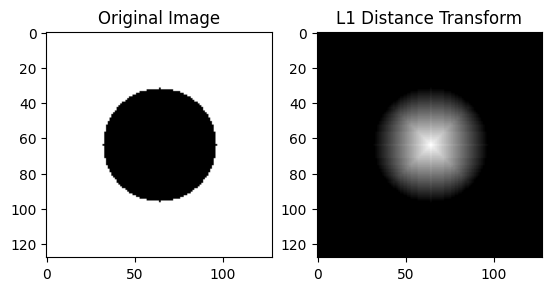

In [323]:
test_mask = np.ones(shape=(128, 128), dtype=bool)
for i in range(128):
    for j in range(128):
        if (i-64)**2 + (j-64)**2 <= 32**2:
            test_mask[i, j] = 0

test_mask_obj = MaskWithBoundary(test_mask)

fig, ax = plt.subplots(nrows=1, ncols=2)

print(f"Bounding box coordinates:")
print(f"    ({test_mask_obj.rmin}, {test_mask_obj.cmin}), ({test_mask_obj.rmax}, {test_mask_obj.cmax})")
print(f"    Max distance from boundary: {np.max(test_mask_obj.mdt)}")

ax[0].imshow(test_mask_obj.array, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(test_mask_obj.mdt, cmap='gray')
ax[1].set_title("L1 Distance Transform")

print(test_mask_obj.mdt[64, 64])

plt.show()

In [324]:
def overlay_mask_image(mask_with_boundary, image, pxs=[], show=True):
    mask_integer = mask_with_boundary.array.astype(np.uint8)
    mask_array = 255 * np.stack((mask_integer,) * 3, axis=-1)

    # Check if the image is grayscale (HxWx1) or RGB (HxWx3)
    if image.shape[-1] == 1:  # Grayscale
        rgb_image = np.stack((image.squeeze(),) * 3, axis=-1)  # Remove the last dimension and stack
    else:  # RGB
        rgb_image = np.copy(image)  # Make a copy of the image

    for (i, j) in pxs:
        rgb_image[i, j] = np.array([0, 0, 255])

    # Blend the image and the mask
    all_mask_pixels = [(i, j) for i in range(mask_array.shape[0]) for j in range(mask_array.shape[1]) if not mask_with_boundary[i, j]]
    interior_rows = [r for (r, _) in all_mask_pixels]
    interior_cols = [c for (_, c) in all_mask_pixels]
    rgb_image[interior_rows, interior_cols] = [255, 255, 255]

    boundary_pixels = list(mask_with_boundary.boundary_pixels)
    boundary_rows = [r for (r, _) in boundary_pixels]
    boundary_cols = [c for (_, c) in boundary_pixels]
    rgb_image[boundary_rows, boundary_cols] = [255, 0, 0]

    if show:
        plt.imshow(rgb_image.astype(np.uint32))
        plt.show()
    else:
        return rgb_image.astype(np.uint32)

In [346]:
# class PatchMatchRemove:
#     def __init__(self, patch_size, image):
#         self.patch_size = patch_size
#         self.patch_area = self.patch_size ** 2

#         self.half_size = patch_size // 2
#         self.image = image.astype(np.float32).reshape((image.shape[0], image.shape[1], -1)) / 255.0
#         self.height, self.width, self.channels = self.image.shape

#         self.ALPHA = 255
#         self.GAMMA = 1.1

#         if self.channels == 1:
#             self.luminance_image = self.image
#         else:
#             # TODO: use better RGB to grayscale conversion
#             self.luminance_image = (np.sum(self.image, axis=-1) / 3).reshape((self.height, self.width, -1))

#     def clamp_idx_to_image(self, i, j):
#         return [
#             min(self.height - self.half_size - 1, max(self.half_size, i)),
#             min(self.width - self.half_size - 1, max(self.half_size, j))
#         ]
    
#     def valid_offset(self, ij, w, a, mask):
#         ox_2d = np.random.uniform(-1, 1, 2)
#         offset = (w * a * ox_2d).astype(np.int64)

#         candidate_idx = self.clamp_idx_to_image(*(ij + offset))
#         candidate_region = PATCH_REGION(*candidate_idx)

#         while not mask[candidate_region].all():
#             ox_2d = np.random.uniform(-1, 1, 2)
#             offset = (w * a * ox_2d).astype(np.int64)

#             candidate_idx = self.clamp_idx_to_image(*(ij + offset))
#             candidate_region = PATCH_REGION(*candidate_idx)
        
#         return offset

#     def interpolate_from_boundary(self, mask):
#         masked_image = self.image * mask[:, :, np.newaxis]
#         n_valid = np.sum(mask.array)

#         avg_pixel = np.empty(shape=(self.channels,))

#         for k in range(self.channels):
#             sumvals = np.sum(masked_image[:, :, k])
#             sumvals /= n_valid
#             avg_pixel[k] = sumvals
        
#         # avg_pixel = np.array([0, 1.0, 0])

#         filled = avg_pixel * ~mask[:, :, np.newaxis]
#         self.image = masked_image + filled

#     def patch_similarity(self, ij_1, ij_2, distances):
#         P1_R = PATCH_REGION(*ij_1)
#         P2_R = PATCH_REGION(*ij_2)

#         # base_offset = n_unmasked / n_total
#         # q = 0.75 * (1 - base_offset) + base_offset
        
#         sigma = np.quantile(distances, q=0.75)

#         dist = np.sum( np.square(self.image[P1_R] - self.image[P2_R]) )
#         sim = np.exp(-dist / (2 * sigma ** 2))
#         # sim = np.exp(-dist)

#         return sim, dist

#     def fill_region(self, mask, n_iters=5):
#         n_total = self.height * self.width
#         n_unmasked = np.sum(mask.array)

#         self.interpolate_from_boundary(mask)

#         nnf_idxs = np.zeros((self.height, self.width, 2), dtype=np.int64)
#         similarities = np.zeros((self.height, self.width))
#         distances = np.zeros_like(similarities)

#         offsets = {
#             0: [np.array([0, 0]), np.array([-1, 0]), np.array([0, -1])],
#             1: [np.array([0, 0]), np.array([1, 0]), np.array([0, 1])]
#         }

#         indices_2d = {
#             0: ([self.half_size, self.height - self.half_size], [self.half_size, self.width - self.half_size]),
#             1: ([self.height - self.half_size, self.half_size - 1, -1], [self.width - self.half_size, self.half_size - 1, -1]),
#         }

#         alpha_weights = np.power(self.GAMMA, -mask.mdt)

#         # return alpha_weights

#         # NNF initialization for masked pixels, uniform in region outside the mask
#         plt.imshow(self.image)
#         plt.show()

#         plt.imshow(alpha_weights, cmap='gray')
#         plt.show()

#         for i in range(self.half_size, self.height - self.half_size):
#             for j in range(self.half_size, self.width - self.half_size):
#                 ij = np.array([i, j])

#                 nnf_init_i, nnf_init_j = i, j
#                 nnf_init_region = PATCH_REGION(nnf_init_i, nnf_init_j)

#                 while not mask[nnf_init_region].all():
#                     nnf_init_i, nnf_init_j = np.random.randint(0, self.height, dtype=int), np.random.randint(0, self.width, dtype=int)
#                     nnf_init_i, nnf_init_j = self.clamp_idx_to_image(nnf_init_i, nnf_init_j)

#                     nnf_init_region = PATCH_REGION(nnf_init_i, nnf_init_j)

#                 nnf_idxs[i, j] = [nnf_init_i, nnf_init_j]

#                 dist = np.sum( np.square(self.image[PATCH_REGION(i, j)] - self.image[nnf_init_region]) )
#                 distances[i, j] = dist
        
#         # base_offset = n_unmasked / n_total
#         # q = 0.75 * (1 - base_offset) + base_offset

#         # sigma = np.quantile(distances, q=q)
#         # print(sigma)

#         for i in range(self.half_size, self.height - self.half_size):
#             for j in range(self.half_size, self.width - self.half_size):
#                 ij = np.array([i, j])

#                 sim, _ = self.patch_similarity(ij, nnf_idxs[i, j], distances)
#                 similarities[i, j] = sim

#         # print(np.max(similarities), np.min(similarities))

#         plt.imshow(distances, cmap='gray')
#         plt.show()

#         # Main PatchMatch algoritm
#         for iter in tqdm(range(n_iters)):
#             sigma = np.quantile(distances, q=q)

#             row_iter_bounds, col_iter_bounds = indices_2d[iter % 2]
#             iter_offsets = offsets[iter % 2]

#             for i in range(*row_iter_bounds):
#                 for j in range(*col_iter_bounds):
#                     if mask[i, j]: continue

#                     ij = np.array([i, j])

#                     for ox in iter_offsets:
#                         partner_i, partner_j = self.clamp_idx_to_image(*(ij + ox))
#                         partner_match_ij = nnf_idxs[partner_i, partner_j]

#                         candidate_match_ij = self.clamp_idx_to_image(*(partner_match_ij - ox))
#                         candidate_match_similarity, candidate_match_dist = self.patch_similarity(ij, candidate_match_ij, distances)

#                         if candidate_match_similarity > similarities[i, j]:
#                             similarities[i, j] = candidate_match_similarity
#                             distances[i, j] = candidate_match_dist
#                             nnf_idxs[i, j] = candidate_match_ij

#                     w = max(self.width, self.height)
#                     a = 1.0

#                     while w * a >= mask.mdt[i, j] + self.half_size + 1:
#                         candidate_offset = self.valid_offset(ij, w, a, mask)
#                         candidate_match_ij = self.clamp_idx_to_image(*(ij + candidate_offset))
#                         # candidate_match_region = PATCH_REGION(*candidate_match_ij)

#                         # if mask[candidate_match_region].all():
#                         candidate_match_similarity, candidate_match_dist = self.patch_similarity(ij, candidate_match_ij, distances)

#                         if candidate_match_similarity > similarities[i, j]:
#                             similarities[i, j] = candidate_match_similarity
#                             distances[i, j] = candidate_match_dist
#                             nnf_idxs[i, j] = candidate_match_ij

#                         a *= 0.5

#             for i in range(*row_iter_bounds):
#                 for j in range(*col_iter_bounds):
#                     if mask[i, j]: continue

#                     total_weight = 0
#                     weighted_color = np.zeros(shape=(self.channels,))

#                     # Iterate through all patches which have pixel (i, j) in it
#                     for pi in range(i - self.half_size, i + self.half_size + 1, 1):
#                         for pj in range(j - self.half_size, j + self.half_size + 1, 1):
#                             if not (0 <= pi < self.height and 0 <= pj < self.width): continue

#                             di, dj = i - pi, j - pj

#                             patch_match_i, patch_match_j = nnf_idxs[pi, pj]
#                             patch_weight = alpha_weights[i, j] * similarities[pi, pj]

#                             total_weight += patch_weight
#                             weighted_color += patch_weight * self.image[patch_match_i + di, patch_match_j + dj, :]

#                     self.image[i, j] = weighted_color / total_weight
#         return distances, similarities, nnf_idxs

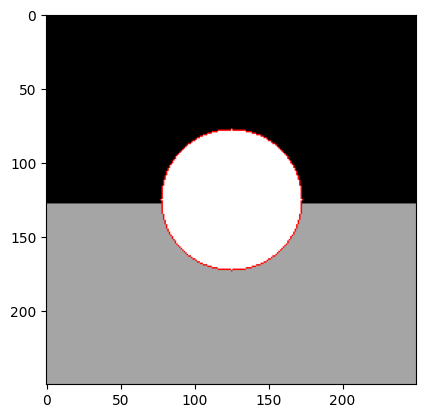

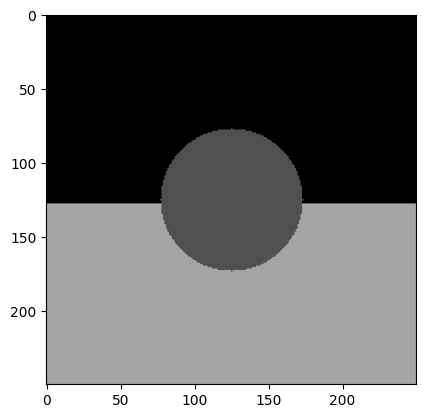

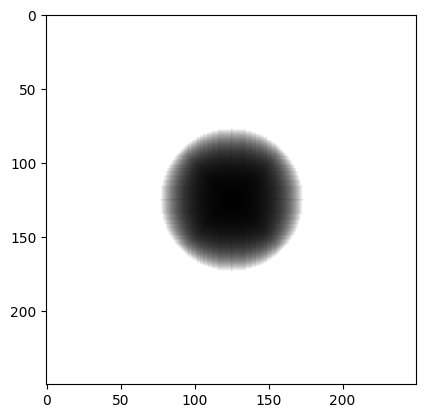

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_53104/2214035164.py:67: RuntimeWarning: invalid value encountered in scalar divide
  sim = np.exp(-dist / (2 * sigma ** 2))
/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_53104/2214035164.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  sim = np.exp(-dist / (2 * sigma ** 2))


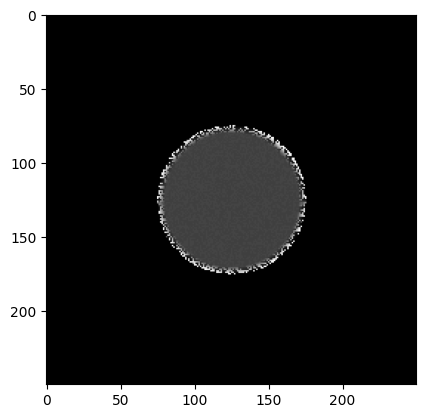

  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'q' is not defined

In [347]:
_img = Image.open('imgs/image1.jpg')
image = np.array(_img)

mask = np.ones((image.shape[0], image.shape[1]), dtype=bool)
center = [image.shape[0]//2, image.shape[1]//2]
radius = 48
y, x = np.ogrid[-center[0]:image.shape[0]-center[0], -center[1]:image.shape[1]-center[1]]
mask[x*x + y*y <= radius*radius] = 0
# mask[60:120, 60:120] = 0
mask_with_boundary = MaskWithBoundary(mask)

overlay_mask_image(mask_with_boundary, image)

# print(mask_with_boundary[PATCH_REGION(77,123)])

objrem = PatchMatchRemove(PATCH_SIZE, image)
objrem.fill_region(mask_with_boundary)
plt.imshow(objrem.image)
plt.show()

# print(aw[80, 125])

# idxr = nnf[center[0]-20, center[0]-5]
# print(mask[PATCH_REGION(*idxr)])
# print(nnf[center[0]-5 : center[0]+5, center[1]-5:center[1]+5, 0])
# print(sims[10:20, 10:20])

In [ ]:
class ObjectRemove:
    def __init__(self, patch_size, image):
        self.patch_size = patch_size
        self.patch_area = self.patch_size ** 2

        self.half_size = patch_size // 2
        self.image = image.astype(np.uint32).reshape((image.shape[0], image.shape[1], -1))
        self.height, self.width, self.channels = self.image.shape

        if self.channels == 1:
            self.luminance_image = self.image
            self.ALPHA = 255
        else:
            # TODO: use better RGB to grayscale conversion
            self.luminance_image = (np.sum(self.image, axis=-1) / 3).reshape((image.shape[0], image.shape[1], -1))
            self.ALPHA = 255

    def clamp_idx(self, ij):
        i, j = ij

        return [
            min(self.height - self.half_size - 1, max(self.half_size, i)),
            min(self.width - self.half_size - 1, max(self.half_size, j))
        ]

    def compute_priority(self, patch_coords, confidence_table, mask):
        i, j = patch_coords
        patch_region = PATCH_REGION(i, j)

        image_3filter = self.luminance_image[i-1:i+2, j-1:j+2]
        mask_3filter = mask[i-1:i+2, j-1:j+2][:, :, np.newaxis]

        confidence = np.sum(mask[patch_region] * confidence_table[patch_region], dtype=float)
        confidence /= self.patch_area

        (img_grad_x, img_grad_y), img_grad_norm = grad(image_3filter)
        boundary_normal, _boundary_grad_norm = grad(mask_3filter)
        
        isophote = img_grad_norm * np.array([-img_grad_y, img_grad_x])

        data = abs(np.dot(isophote, boundary_normal))
        data /= self.ALPHA

        return confidence, data
    
    def compute_distance(self, patch_coords, exemp_coords, mask):
        ip, jp = patch_coords
        ie, je = exemp_coords

        patch_region = PATCH_REGION(ip, jp)
        exemp_region = PATCH_REGION(ie, je)

        patch_mask = mask[patch_region][:, :, np.newaxis]

        patch_mask_sum = np.sum(patch_mask, dtype=float)
        patch_mask_not_sum = np.sum(~patch_mask, dtype=float)

        # compute MSD
        M_p = patch_mask * self.image[patch_region]
        M_e = patch_mask * self.image[exemp_region]

        msd = np.sum((M_p - M_e) ** 2, dtype=float)
        msd /= patch_mask_sum

        # compute SMD
        smd1 = np.sum(patch_mask * self.image[patch_region], dtype=float)
        smd2 = np.sum(~patch_mask * self.image[exemp_region], dtype=float)

        smd1 /= patch_mask_sum
        smd2 /= patch_mask_not_sum

        smd = (smd1 - smd2) ** 2

        return msd + smd

    def fill_region(self, mask, n_exemplar_samples=10):
        assert mask.array.shape[0] == self.image.shape[0] and mask.array.shape[1] == self.image.shape[1]
        max_dim = max(self.image.shape)
            
        timing_specs = {
            'priorities': [0, 0],
            'exemplar': [0, 0],
            'fill': [0, 0],
        }

        # initialize confidence table to 0 for masked pixels, 1 for unmasked pixels
        confidence_table = mask.array.copy().astype(np.float32)
        n_iters = 0

        tot_n_tries = 0

        while not mask.empty():
            n_iters += 1

            start_time = time.time()

            priorities = {(i, j) : self.compute_priority((i, j), confidence_table, mask) for (i, j) in mask.boundary_pixels}
            ip, jp = max(priorities, key=lambda x: priorities[x][0] *  priorities[x][1])

            end_time = time.time()
            timing_specs['priorities'][1] = max(timing_specs['priorities'][1], end_time - start_time)
            timing_specs['priorities'][0] += end_time - start_time

            start_time = time.time()
            
            patch_region = PATCH_REGION(ip, jp)
            mask_region = mask[patch_region][:, :, np.newaxis] 

            max_confidence, _ = priorities[(ip, jp)]

            exemplar_distance = float('inf')
            exemplar_i, exemplar_j = None, None
            n_candidates = 0
            
            # Randomized search for exemplar patch
            w = max_dim
            alpha = 1.0
            cnt = 0
            
            while (w * alpha) > self.patch_size:
                random_2d = np.random.uniform(-1, 1, 2)
                offset = w * alpha * random_2d

                i, j = ip + int(offset[0]), jp + int(offset[1])
                ic, jc = self.clamp_idx((i, j))
                exemplar_region_c = PATCH_REGION(ic, jc)

                if np.sum(mask[exemplar_region_c]) == self.patch_area:
                    n_candidates += 1

                    c_exemplar_distance = self.compute_distance((ip, jp), (ic, jc), mask)
                    
                    if c_exemplar_distance < exemplar_distance:
                        exemplar_distance = c_exemplar_distance
                        exemplar_i, exemplar_j = ic, jc
                    
                    alpha *= 0.75
            #     cnt += 1
            # else:
            #     print(f"failed at {cnt}")
            # n_tries = 0
            # while n_candidates < 100:
            #     n_tries += 1
            #     s = 2
            #     offset = np.random.multivariate_normal([0, 0], [[max_dim / s, 0], [0, max_dim / s]])
            #     i, j = ip + int(offset[0]), jp + int(offset[1])
                
            #     ic, jc = self.clamp_idx((i, j))
            #     exemplar_region_c = PATCH_REGION(ic, jc)

            #     if np.sum(mask[exemplar_region_c]) == self.patch_area:
            #         n_candidates += 1

            #         c_exemplar_distance = self.compute_distance((ip, jp), (ic, jc), mask)
                    
            #         if c_exemplar_distance < exemplar_distance:
            #             exemplar_distance = c_exemplar_distance
            #             exemplar_i, exemplar_j = ic, jc
            # tot_n_tries += n_tries
            """
            # Brute force search for exemplar patch

            for i in range(self.half_size, self.height - self.half_size, 1):
                for j in range(self.half_size, self.width - self.half_size, 1):
                    r = PATCH_REGION(i, j)
                    if np.sum(mask[r], dtype=int) != self.patch_area: continue

                    c_exemplar_distance = self.compute_distance((ip, jp), (i, j), mask)

                    if c_exemplar_distance < exemplar_distance:
                        exemplar_distance = c_exemplar_distance
                        exemplar_i, exemplar_j = i, j
            """

            end_time = time.time()
            timing_specs['exemplar'][1] = max(timing_specs['exemplar'][1], end_time - start_time)
            timing_specs['exemplar'][0] += end_time - start_time

            start_time = time.time()

            if self.channels == 3:
                self.image[patch_region] *=  mask_region
                self.image[patch_region] += ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)]

                self.luminance_image[patch_region] *=  mask_region
                self.luminance_image[patch_region] += ~mask_region * self.luminance_image[PATCH_REGION(exemplar_i, exemplar_j)]
            else:
                self.image[patch_region] *=  mask_region
                self.image[patch_region] += ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)]

            confidence_table[patch_region] *= mask_region[:, :, 0]
            confidence_table[patch_region] += ~mask_region[:, :, 0] * max_confidence

            mask.fill_patch(ip, jp)

            end_time = time.time()
            timing_specs['fill'][1] = max(timing_specs['fill'][1], end_time - start_time)
            timing_specs['fill'][0] += end_time - start_time

        plt.imshow(self.image, cmap='gray')
        plt.title("Inpainted Image")
        plt.show()

        plt.imshow(confidence_table, cmap='gray')
        plt.title("Confidence Table")
        plt.show()

        print(tot_n_tries/n_iters)
        print(f"Timing stats over {n_iters} iterations:")
        for x in timing_specs:
            print(f"{x}: {timing_specs[x][0] / n_iters * 1e3} ms avg, {timing_specs[x][1] * 1e3} ms max")

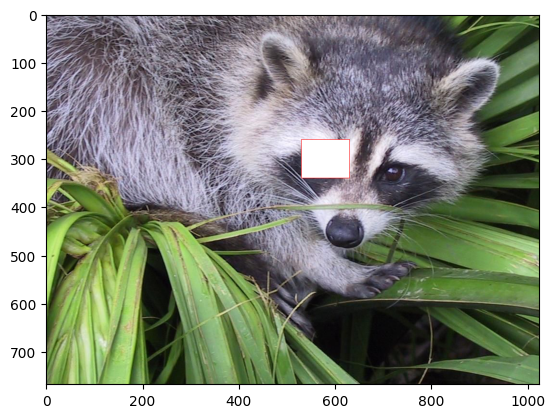

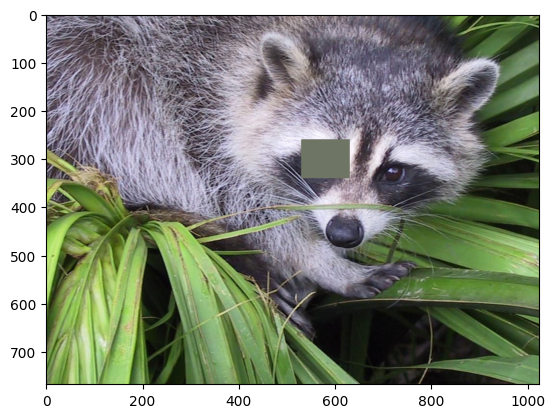

In [61]:
# image = (255 * np.ones((128, 128), dtype=int)).reshape((128, 128, -1))
# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         if (i + 2 * j >= 170):
#             image[i, j] = 0

image = datasets.face().astype('int32')

mask = np.ones((image.shape[0], image.shape[1]), dtype=bool)
box_w, box_h = 100, 80
mask[300-box_h//2 : 300+box_h//2+1, 580-box_w//2 : 580+box_w//2+1] = False
mask_with_boundary = MaskWithBoundary(mask)

overlay_mask_image(mask_with_boundary, image)

objrem = PatchMatchRemove(PATCH_SIZE, image)
objrem.interpolate_from_boundary(mask_with_boundary)

plt.imshow(objrem.image)

# objrem = ObjectRemove(PATCH_SIZE, image)
# objrem.fill_region(mask_with_boundary)